### Group ID: Group 160
### Group Members Name with Student ID:
1. HEMANT KUMAR PARAKH (2023AA05741)
2. SUSHIL KUMAR (2023aa05849)
3. NAGINENI SATISH BABU (2023aa05585)
4. JITENDRA KUMAR (2023aa05198)

#Part I - Understanding the Dataset and Preprocessing

## Loading the dataset

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Load the provided dataset.

In [3]:
try:
  df = pd.read_csv('/content/NER Dataset PS-6 - NER Dataset.csv',index_col=0)
except:
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP-Assignment-1/NER Dataset PS-6 - NER Dataset.csv',index_col=0)

##### Display the first few rows.

In [4]:
print(df.head(10).to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  tokens                                                                                                                                                                                                       ner_tags


## Exploratory Data Analysis

In [5]:
!pip install nltk
!pip install gensim

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##### Count the number of sentences.

In [7]:
print("Number of rows in dataset: ",len(df))

Number of rows in dataset:  108378


In [8]:
#Check duplicate rows in data
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape)

Number of duplicate rows ::  (13319, 2)


In [9]:
# Google colab is crashing due to complate RAM usages. Reduce the sample size of the original data
#df_sampled = df.sample(frac=0.50, random_state=42)
df_sampled = df

In [10]:
# Drop duplicate rows
df_sampled.drop_duplicates(inplace=True)

In [11]:
#number of rows after dropping duplicate
print("Number of rows after dropping duplicate: ", len(df_sampled))

Number of rows after dropping duplicate:  95059


####Count the number of sentences

In [12]:
# Count the number of sentences
num_sentences = df['tokens'].apply(lambda x: len(x)).sum()
print(f"Number of sentences: {num_sentences}")

Number of sentences: 35407394


### Identify the unique POS tags and named entity tags.

In [13]:
# Clean tokens and remove unwanted characters
def clean_token(token):
    cleaned_token = re.sub(r'[\[\]\n\'"]', '', token)
    return cleaned_token.strip()

# Function to clean NER tags
def clean_ner_tags(tags):
    try:
        # Handle special format '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.'
        tags = tags.strip('[]').replace('.', '').split()
        tags_list = [int(tag) for tag in tags]
        cleaned_tags = [str(tag) for tag in tags_list]  # Convert back to string if needed
        return cleaned_tags
    except (ValueError, TypeError):
        return []

# Apply cleaning to 'tokens' column
df_sampled['cleaned_tokens'] = df_sampled['tokens'].apply(lambda tokens: [clean_token(token) for token in tokens.split(',')])

# Apply cleaning to 'ner_tags' column
if 'ner_tags' in df_sampled.columns:
    df_sampled['cleaned_ner_tags'] = df_sampled['ner_tags'].apply(clean_ner_tags)
else:
    print("Error: 'ner_tags' column not found in dataset or not properly loaded.")

# Calculate unique NER tags
unique_ner_tags = set(tag for tags in df_sampled['cleaned_ner_tags'] for tag in tags)

# Function to clean POS tags
def clean_pos_tags(tags):
    cleaned_tags = [(re.sub(r'[^a-zA-Z0-9\s]', '', tag), pos) for tag, pos in tags]
    return [(word, pos) for word, pos in cleaned_tags if word]

# Perform POS tagging
def perform_pos_tagging(tokens):
    tokens_text = ' '.join(tokens)
    tokens_words = word_tokenize(tokens_text)
    return nltk.pos_tag(tokens_words)

# Apply POS tagging and cleaning to 'tokens'
df_sampled['cleaned_pos_tags'] = df_sampled['cleaned_tokens'].apply(perform_pos_tagging).apply(clean_pos_tags)

print(f"Sample of DataFrame with cleaned POS tags:\n{df_sampled[['tokens', 'cleaned_pos_tags']].head()}")

# Print unique NER tags for verification
print(f"\nUnique NER tags: {unique_ner_tags}")

# Optionally, you can print unique POS tags for verification
tokens = [token for sublist in df_sampled['cleaned_tokens'] for token in sublist]
tokens_text = ' '.join(tokens)
tokens_words = word_tokenize(tokens_text)
#unique_pos_tags = nltk.pos_tag(tokens_words)

batch_size = 10000  # Adjust based on available memory
unique_pos_tags = []
for i in range(0, len(tokens_words), batch_size):
    batch_tags = nltk.pos_tag(tokens_words[i: i + batch_size])
    unique_pos_tags.extend(batch_tags)

unique_pos_tags = set(unique_pos_tags)

print(f"\nUnique POS tags: {unique_pos_tags}")

Sample of DataFrame with cleaned POS tags:
                                                    tokens  \
id                                                           
1012878  ['The' 'changes' 'in' 'the' 'fair' 'value' 'of...   
1012879  ['Fair' 'Values' 'Financial' 'Assets' 'and' 'F...   
1012880  ['23' 'Table' 'of' 'Contents' 'AMERICAN' 'EXPR...   
1012881  ['The' 'fair' 'values' 'of' 'these' 'financial...   
1012882  ['(' 'b' ')' 'Level' '1' 'amounts' 'reflect' '...   

                                          cleaned_pos_tags  
id                                                          
1012878  [(The, DT), (changes, NNS), (in, IN), (the, DT...  
1012879  [(Fair, NNP), (Values, NNP), (Financial, NNP),...  
1012880  [(23, CD), (Table, NN), (of, IN), (Contents, N...  
1012881  [(The, DT), (fair, JJ), (values, NNS), (of, IN...  
1012882  [(b, NN), (Level, NN), (1, CD), (amounts, NNS)...  

Unique NER tags: {'37', '48', '86', '132', '18', '155', '35', '165', '113', '80', '7', '34', '

### Visualize the distribution of sentence lengths.

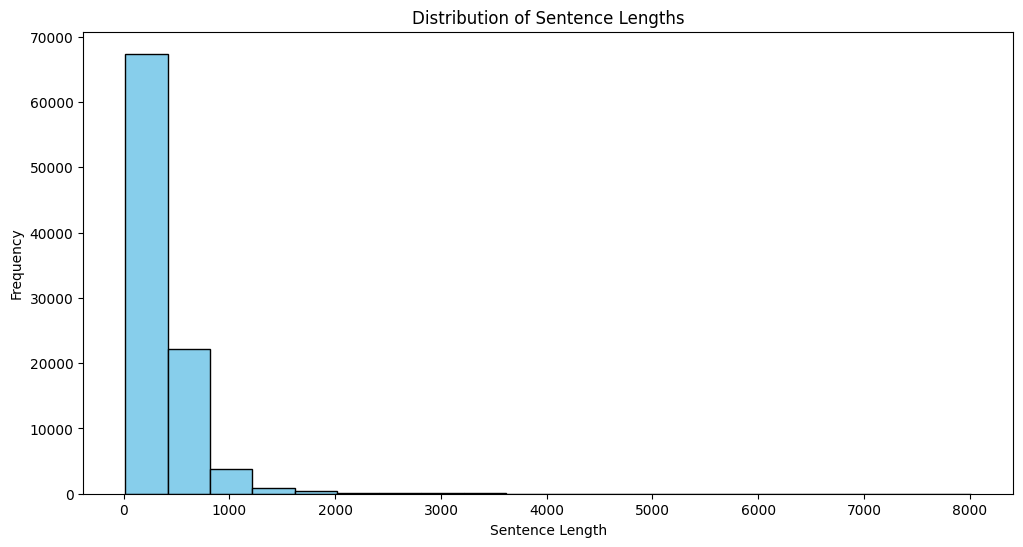

In [14]:
# Distribution of sentence lengths
sentence_lengths = df['tokens'].apply(len)

plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()


####Observations:

Right-Skewed Distribution: The distribution is heavily right-skewed, meaning the majority of sentences have shorter lengths, while a small number of sentences are significantly longer.

Range of Sentence Lengths: The sentence lengths range from 0 to about 8000, but the frequency drops off sharply after around 1000. Most sentences seem to be less than 1000 characters long.

Frequency of Short Sentences: The highest frequency is for sentences with lengths between 0 and 500 characters. This suggests that short sentences are much more common in the dataset.

Outliers: There are a few sentences that are extremely long, which can be seen in the long tail of the distribution.

Visualization: The use of bins and the x-axis range effectively show the skewness and concentration of data points.

### Visualize the frequency of different POS tags.

Unique POS tags:  {'37', '48', '86', '132', '18', '155', '35', '165', '113', '80', '7', '34', '149', '88', '160', '128', '50', '67', '77', '49', '126', '121', '53', '2', '163', '161', '17', '68', '105', '22', '1', '152', '82', '52', '57', '108', '139', '25', '81', '115', '27', '73', '61', '29', '6', '99', '98', '142', '89', '137', '10', '94', '12', '107', '169', '95', '21', '36', '43', '14', '66', '59', '112', '93', '60', '55', '131', '56', '147', '62', '114', '33', '74', '85', '143', '69', '122', '5', '168', '127', '159', '134', '97', '78', '58', '83', '145', '41', '130', '8', '129', '164', '24', '151', '47', '76', '0', '70', '154', '51', '64', '136', '44', '20', '87', '102', '75', '79', '90', '158', '46', '167', '111', '153', '32', '19', '109', '116', '4', '144', '30', '120', '42', '103', '100', '26', '91', '92', '39', '84', '23', '125', '150', '13', '106', '140', '40', '31', '138', '133', '72', '3', '28', '16', '63', '54', '71', '124', '148', '118', '119', '101', '45', '104', '156'}

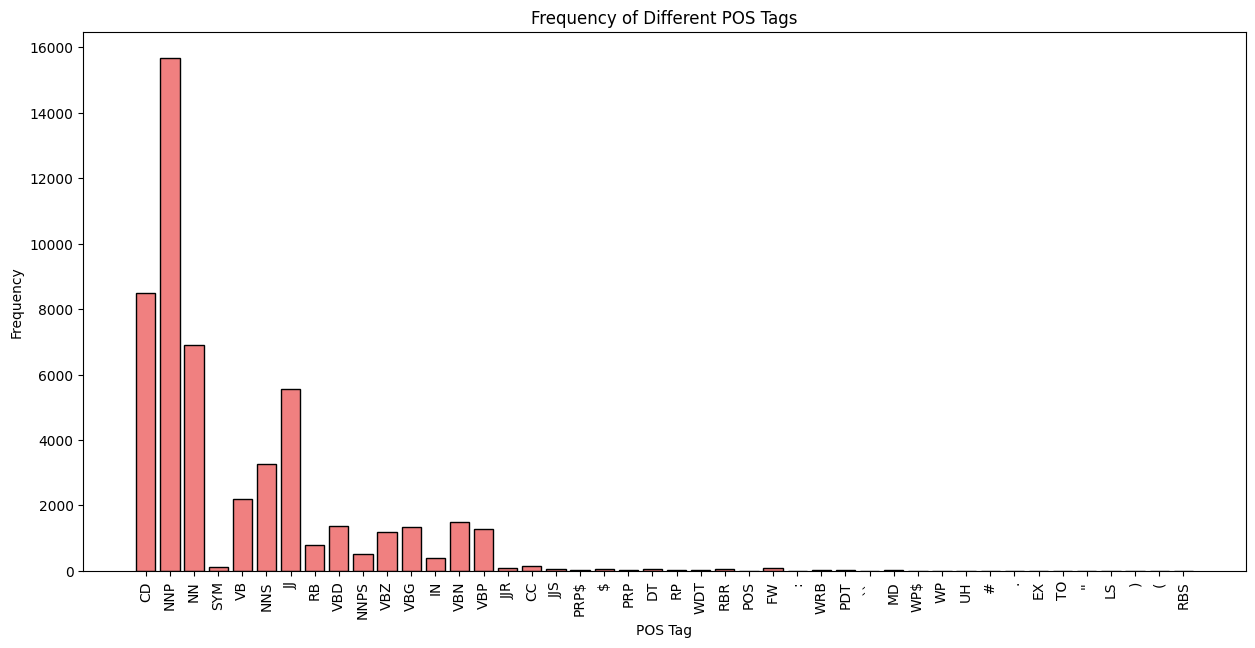

In [15]:
pos_tags_only = [tag for word, tag in unique_pos_tags]

# Count the frequency of each POS tag
pos_counts = Counter(pos_tags_only)

# Assuming the NER tags include POS tags (for this dataset)
unique_pos_tags = unique_ner_tags
print("Unique POS tags: ", unique_pos_tags)

# Plot the frequency of different POS tags
plt.figure(figsize=(15, 7))
plt.bar(pos_counts.keys(), pos_counts.values(), color='lightcoral', edgecolor='black')
plt.title('Frequency of Different POS Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

####Observations:
Common POS Tags: The most common POS tags are NN (singular noun), IN (preposition or subordinating conjunction), and NNP (proper noun, singular). These tags have the highest frequencies, indicating that nouns and prepositions are prevalent in the dataset.

Distribution: There is a wide range of POS tags present, with frequencies varying significantly. Some tags have very high frequencies, while others have relatively low frequencies.

### Data Preprocessing

#### Tokenize the sentences and map each word to its corresponding POS and named entity tags.

In [16]:
from collections import defaultdict, Counter

# Tokenize the sentences and map each word to its corresponding POS and named entity tags
word2idx = defaultdict(lambda: len(word2idx))
pos2idx = defaultdict(lambda: len(pos2idx))
ner2idx = defaultdict(lambda: len(ner2idx))

# Special tokens
word2idx["<PAD>"]
word2idx["<UNK>"]

pos2idx["<PAD>"]
ner2idx["<PAD>"]

# Populate the dictionaries
for sentence in tokens:
    for word in sentence:
        word2idx[word]

for tags in pos_tags_only:
    for tag in tags:
        pos2idx[tag]

for tags in unique_ner_tags:
    for tag in tags:
        ner2idx[tag]

# For debugging and validation, print the word, POS, and NER dictionaries
print("\nWord to Index Dictionary (Sample):", dict(list(word2idx.items())[:10]))
print("\nPOS to Index Dictionary (Sample):", dict(list(pos2idx.items())[:10]))
print("\nNER to Index Dictionary (Sample):", dict(list(ner2idx.items())[:10]))



Word to Index Dictionary (Sample): {'<PAD>': 0, '<UNK>': 1, 'T': 2, 'h': 3, 'e': 4, ' ': 5, 'c': 6, 'a': 7, 'n': 8, 'g': 9}

POS to Index Dictionary (Sample): {'<PAD>': 0, 'C': 1, 'D': 2, 'N': 3, 'P': 4, 'S': 5, 'Y': 6, 'M': 7, 'V': 8, 'B': 9}

NER to Index Dictionary (Sample): {'<PAD>': 0, '3': 1, '7': 2, '4': 3, '8': 4, '6': 5, '1': 6, '2': 7, '5': 8, '0': 9}


##### Convert the words and tags into numerical representations suitable for modelling, such as word indices and tag indices.

In [17]:
# Convert words and tags to indices
tokens_idx = [[word2idx[word] for word in sentence] for sentence in tokens]
pos_tags_idx = [[pos2idx[tag] for tag in tags] for tags in pos_tags_only]
ner_tags_idx = [[ner2idx[tag] for tag in tags] for tags in unique_ner_tags]

# Print some examples
print("Example token indices:", tokens_idx[0][:10])
print("Example POS tag indices:", pos_tags_idx[0][:10])
print("Example NER tag indices:", ner_tags_idx[0][:10])


Example token indices: [2, 3, 4, 5, 6, 3, 7, 8, 9, 4]
Example POS tag indices: [1, 2]
Example NER tag indices: [1, 2]


#Part II - Word Embedding using Word2Vec

###Word2Vec Model Implementation

####Implement a Word2Vec model to generate word embeddings from the dataset.
#####Ensure your model captures the contextual relationships between words effectively.

In [18]:
# Assume df is already loaded and contains 'tokens' and 'ner_tags' columns

# Clean special characters function
def clean_special_characters(token):
    special_characters = "!@#$%^&*()_+=-[]{}|:;',.<>/?"
    return token.replace(special_characters, '')

print("Sample tokens from df_sampled:")
for tokens in df_sampled['cleaned_tokens'][:5]:  # Print tokens from first 5 rows for inspection
    print(tokens)

# Example DataFrame 'df_sampled' assumed to contain tokens in 'token_column'
cleaned_tokens = []
for token in df_sampled['tokens']:
  token = re.sub(r'([.,!?;:])', r' \1 ', token)
  # Remove non-alphanumeric characters except spaces and hyphens
  cleaned_token = re.sub(r'[^a-zA-Z0-9\s]', '', token)
  cleaned_tokens.append(cleaned_token)


# Example DataFrame 'df_sampled' assumed to contain tokens in 'token_column'
cleaned_ner_tags = []
for ner_tag in df_sampled['ner_tags']:
  ner_tag = re.sub(r'([.,!?;:])', r' \1 ', ner_tag)
  # Remove non-alphanumeric characters except spaces and hyphens
  cleaned_ner_tag = re.sub(r'[^a-zA-Z0-9\s-]', '', ner_tag)
  cleaned_ner_tags.append(cleaned_ner_tag)

# Replace the original 'token_column' with cleaned tokens
df_sampled['tokens'] = cleaned_tokens

# Replace the original 'token_column' with cleaned tokens
df_sampled['ner_tags'] = cleaned_ner_tags




print("Sample tokens from df_sampled:")
for tokens in df_sampled['tokens'][:5]:  # Print tokens from first 5 rows for inspection
    print(tokens)


if 'id' not in df_sampled.columns:
    df_sampled['id'] = range(len(df_sampled))  # Assign a unique id to each row

num_sentences = df_sampled['id'].nunique()
print(f"Number of sentences after cleaning: {num_sentences}")

Sample tokens from df_sampled:
['The changes in the fair value of the derivatives and the related underlying foreign currency exposures resulted in net gains of $ 11 million and $ 23 million for the three months ended March 31', '2020 and 2019', 'respectively', 'that are recognized in Other', 'net expenses on the Consolidated Statements of Income . 5 .']
['Fair Values Financial Assets and Financial Liabilities Carried at Fair Value The following table summarizes Credco ’ s financial assets and financial liabilities measured at fair value on a recurring basis', 'categorized by GAAP ’ s fair value hierarchy as Level 2', 'as of March 31', '2020 and December 31', '2019 : ( a ) Refer to Note 4 for the fair values of derivative assets and liabilities', 'on a further disaggregated basis .']
['23 Table of Contents AMERICAN EXPRESS CREDIT CORPORATION NOTES TO CONSOLIDATED FINANCIAL STATEMENTS ( Unaudited ) Financial Assets and Financial Liabilities Carried at Other Than Fair Value The following

In [19]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Step 3: Word Embedding using Word2Vec
# Tokenize the sentences
sentences = df_sampled['tokens'].tolist()

# Ensure 'cleaned_tokens' column contains lists of words (tokenized sentences)
tokenized_sentences = df_sampled['cleaned_tokens'].tolist()

print("Sample tokens from df_sampled:")
for tokens in tokenized_sentences[:5]:  # Print tokens from first 5 rows for inspection
    print(tokens)

# Train the Word2Vec model
vector_size = 100  # Dimensionality of the word vectors
window = 5  # Context window size
min_count = 1  # Minimum frequency of words to consider
workers = 4  # Number of parallel threads for training
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)

Sample tokens from df_sampled:
['The changes in the fair value of the derivatives and the related underlying foreign currency exposures resulted in net gains of $ 11 million and $ 23 million for the three months ended March 31', '2020 and 2019', 'respectively', 'that are recognized in Other', 'net expenses on the Consolidated Statements of Income . 5 .']
['Fair Values Financial Assets and Financial Liabilities Carried at Fair Value The following table summarizes Credco ’ s financial assets and financial liabilities measured at fair value on a recurring basis', 'categorized by GAAP ’ s fair value hierarchy as Level 2', 'as of March 31', '2020 and December 31', '2019 : ( a ) Refer to Note 4 for the fair values of derivative assets and liabilities', 'on a further disaggregated basis .']
['23 Table of Contents AMERICAN EXPRESS CREDIT CORPORATION NOTES TO CONSOLIDATED FINANCIAL STATEMENTS ( Unaudited ) Financial Assets and Financial Liabilities Carried at Other Than Fair Value The following

##Word Embedding Visualization

####Visualize the word embeddings using techniques such as t-SNE or PCA. Display how different words and their embeddings relate to each other in a lowerdimensional space.


id
1012878    [The changes in the fair value of the derivati...
1012879    [Fair Values Financial Assets and Financial Li...
1012880    [23 Table of Contents AMERICAN EXPRESS CREDIT ...
1012881    [The fair values of these financial instrument...
1012882    [( b ) Level 1 amounts reflect interest - bear...
Name: cleaned_tokens, dtype: object


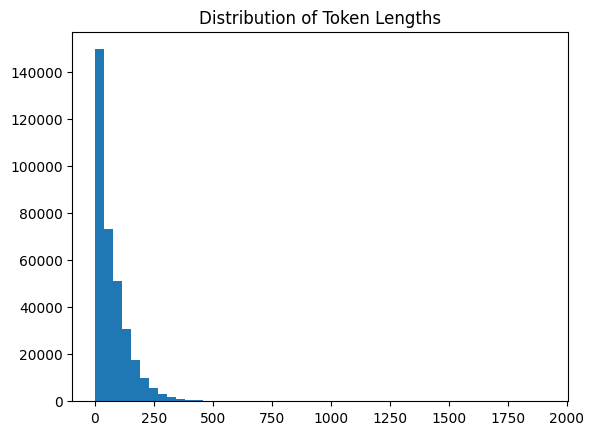

Number of empty tokens: 1
Vocabulary size: 236267
Vocabulary size: 236267
'the' is NOT in the vocabulary
'and' is in the vocabulary
'a' is NOT in the vocabulary
'of' is NOT in the vocabulary
'to' is in the vocabulary


In [20]:
# Print the first few sentences in your dataset to check for issues
print(df_sampled['cleaned_tokens'].head())

# Check the distribution of token lengths
token_lengths = [len(token) for tokens in df_sampled['cleaned_tokens'] for token in tokens]
plt.hist(token_lengths, bins=50)
plt.title('Distribution of Token Lengths')
plt.show()

# Check for empty tokens
empty_tokens = [token for tokens in df_sampled['cleaned_tokens'] for token in tokens if token == '']
print("Number of empty tokens:", len(empty_tokens))

df_sampled['cleaned_tokens'] = df_sampled['cleaned_tokens'].apply(lambda tokens: [token.lower() for token in tokens])

w2v_model = Word2Vec(sentences=df_sampled['cleaned_tokens'], min_count=1, window=5)  # Retrain with adjusted data
print("Vocabulary size:", len(w2v_model.wv))  # Check vocabulary size
# ... (Check for specific words again)

# Print vocabulary size
print("Vocabulary size:", len(w2v_model.wv))

# Check if specific words are in the vocabulary
test_words = ["the", "and", "a", "of", "to"]  # Replace with relevant words from your dataset
for word in test_words:
    if word in w2v_model.wv:
        print(f"'{word}' is in the vocabulary")
    else:
        print(f"'{word}' is NOT in the vocabulary")

Words in model's vocabulary (first 50): ['coronavirus', 'outbreak', 'in', 'january', '2020', 'the', 'full', 'extent', 'to', 'which', 'covid-19', 'will', 'impact', 'our', 'business', 'the', 'joint', 'venture', 'has', 'not', 'had', 'any', 'borrowings', 'under', 'the', 'credit', 'facility', 'during', 'the', 'last', 'two', 'fiscal', 'years', ';', 'therefore', 'or', '19', '%', 'whether', 'acting', 'directly', 'or', 'indirectly', 'through', 'authorized', 'telemarketers', 'or', 'independent', 'third', '-']
word_vectors: [[ 0.00136798 -0.00252388 -0.0010146  ...  0.00644375  0.00752514
  -0.00959395]
 [ 0.00375641  0.00508116  0.00296998 ...  0.00055501  0.00508581
   0.00070315]
 [-0.00394509 -0.00604184  0.00956834 ...  0.00662837  0.00336835
   0.00173699]
 ...
 [ 0.00893088  0.00469499 -0.00883255 ...  0.00146034 -0.00632154
   0.00511893]
 [ 0.00893093 -0.00164748  0.00544255 ... -0.00806205  0.00230497
  -0.00822644]
 [ 0.00360608  0.00876483 -0.00863149 ... -0.00132596  0.00759266
   0.

<ipython-input-21-9a494cb5f700>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(words_to_show))


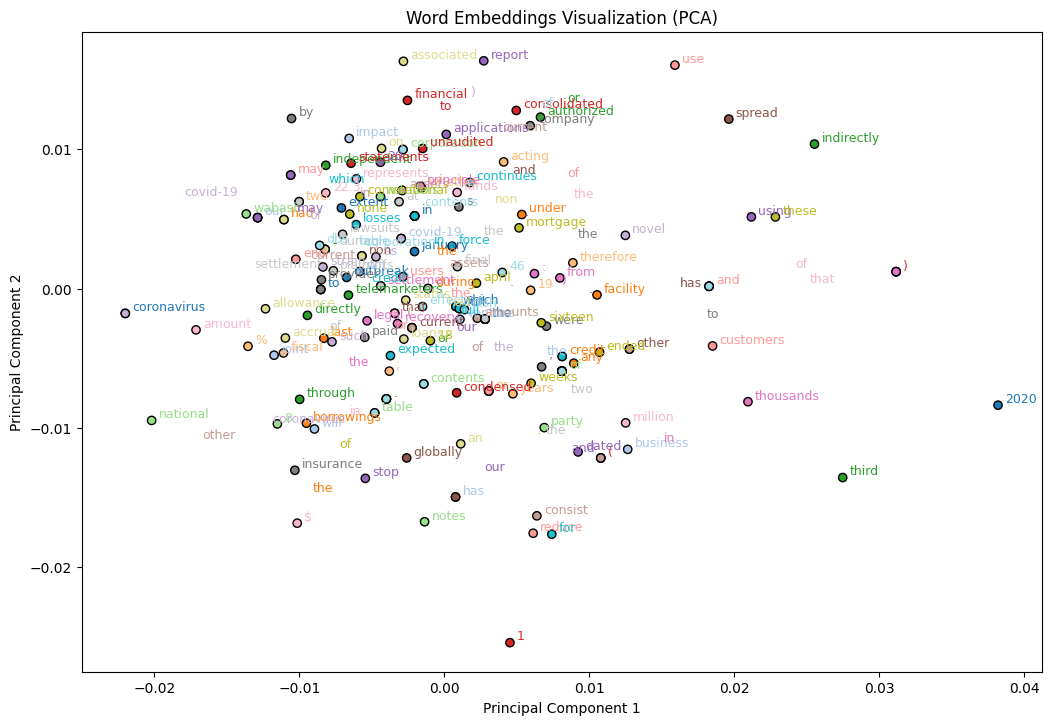

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

def flatten_list_of_lists(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]

def break_into_words(phrases):
    words = []
    for phrase in phrases:
        words.extend(phrase.split())
    return words

def visualize_embeddings_pca(w2v_model, vocab, num_words_to_show=200):


    # Check which words in vocab are in the model's vocabulary
    in_model_vocab = [word for word in vocab if word in w2v_model.wv]
    words = break_into_words(in_model_vocab)
    print("Words in model's vocabulary (first 50):", words[:50])  # Debug print

    # Get word vectors from Word2Vec model, handling missing words
    word_vectors = np.array([w2v_model.wv[word] for word in in_model_vocab if word in w2v_model.wv])
    print("word_vectors:", word_vectors[:50])
    print("Word vectors shape:", word_vectors.shape)  # Debug print

    # Check if any word vectors were found
    if word_vectors.size == 0:
        print("No word vectors found. Check your vocabulary and model.")
        return

    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    word_vectors_pca = pca.fit_transform(word_vectors)

    # Select a subset of words to display
    words_to_show = words[:num_words_to_show]
    indices_to_show = [words.index(word) for word in words_to_show]

    print("Words to show:", words_to_show[:10])  # Debug print
    print("Indices to show:", indices_to_show[:10])  # Debug print

    # Generate colors for each word
    colors = plt.cm.get_cmap('tab20', len(words_to_show))

    # Plot
    plt.figure(figsize=(12, 8))  # Adjust figure size if needed
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.scatter(word_vectors_pca[indices_to_show, 0], word_vectors_pca[indices_to_show, 1],
                c=range(len(indices_to_show)), cmap=colors, edgecolors='k')

    # Annotate points
    for i, word in enumerate(words_to_show):
        plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]),
                     fontsize=9, color=colors(i % len(words_to_show)),
                     xytext=(5, 2), textcoords='offset points')

    plt.title("Word Embeddings Visualization (PCA)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Assuming w2v_model is already defined and trained with df_sampled['cleaned_tokens']
# Adjust vocab creation based on your specific data structure

# Assuming w2v_model is already defined and trained with df_sampled['cleaned_tokens']
tokens = flatten_list_of_lists(df_sampled['cleaned_tokens'])
vocab = list(set(tokens))

# Example usage of the visualization function
visualize_embeddings_pca(w2v_model, vocab[:500])  # Visualize PCA with first 500 words


Words in model's vocabulary (first 50): ['2020', 'extent', 'to', 'which', 'covid-19', 'will', 'our', 'business', 'borrowings', 'credit', 'facility', 'two', 'fiscal', 'therefore', 'or', '19', 'or', 'indirectly', 'or', 'third', '8', 'national', 'notes', 'to', 'financial', ')', '1', '.', 'customers', 'and', 'may', 'use', 'or', 'using', 'our', 'applications', 'and', 'our', 'dated', 'may', '20', 'as', 'covid-19', ')', 'that', 'spread', '.', 'other', 'current', 'and']
word_vectors: [[-2.2502722e-01  4.4853720e-01  8.1816202e-01 ... -1.0915360e+00
  -6.5614156e-02 -8.2492478e-02]
 [ 6.3172826e-03  3.7620573e-03  3.4539264e-03 ... -1.3123533e-03
  -9.7428467e-03  2.5751905e-03]
 [-8.0127548e-04 -1.4746604e-02  1.6915370e-04 ... -4.0064119e-03
   2.4183607e-03 -6.7624205e-04]
 ...
 [-1.5966949e-04  7.3280381e-03  7.9114893e-03 ... -7.4006892e-03
   4.0754382e-03 -3.2819100e-03]
 [-6.7008995e-03  7.7596926e-03 -1.1446671e-04 ... -4.1495208e-03
  -1.2937970e-03  7.3160082e-03]
 [-3.5340171e-02  1

<ipython-input-22-33c1267fc560>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(words_to_show))


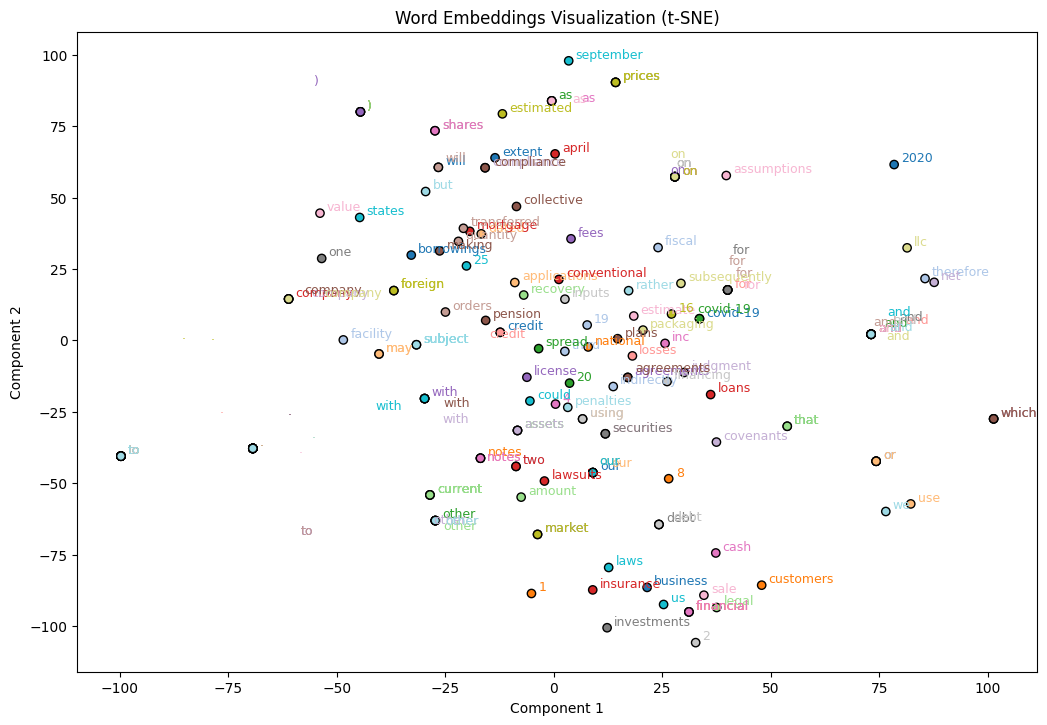

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

def flatten_list_of_lists(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]

def break_into_words(phrases):
    words = []
    for phrase in phrases:
        words.extend(phrase.split())
    return words

def visualize_embeddings_tsne(w2v_model, vocab, num_words_to_show=200):
    # Break sentences into words
    words = break_into_words(vocab)

    # Check which words in vocab are in the model's vocabulary
    in_model_vocab = [word for word in words if word in w2v_model.wv]
    print("Words in model's vocabulary (first 50):", in_model_vocab[:50])  # Debug print

    # Get word vectors from Word2Vec model, handling missing words
    word_vectors = np.array([w2v_model.wv[word] for word in in_model_vocab if word in w2v_model.wv])
    print("word_vectors:", word_vectors[:50])
    print("Word vectors shape:", word_vectors.shape)  # Debug print

    # Check if any word vectors were found
    if word_vectors.size == 0:
        print("No word vectors found. Check your vocabulary and model.")
        return

    # Reduce dimensions with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    word_vectors_tsne = tsne.fit_transform(word_vectors)

    # Select a subset of words to display
    words_to_show = in_model_vocab[:num_words_to_show]
    indices_to_show = [in_model_vocab.index(word) for word in words_to_show]

    print("Words to show:", words_to_show[:10])  # Debug print
    print("Indices to show:", indices_to_show[:10])  # Debug print

    # Generate colors for each word
    colors = plt.cm.get_cmap('tab20', len(words_to_show))

    # Plot
    plt.figure(figsize=(12, 8))  # Adjust figure size if needed
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.scatter(word_vectors_tsne[indices_to_show, 0], word_vectors_tsne[indices_to_show, 1],
                c=range(len(indices_to_show)), cmap=colors, edgecolors='k')

    # Annotate points
    for i, word in enumerate(words_to_show):
        plt.annotate(word, xy=(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]),
                     fontsize=9, color=colors(i % len(words_to_show)),
                     xytext=(5, 2), textcoords='offset points')

    plt.title("Word Embeddings Visualization (t-SNE)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Example usage assuming df_sampled['cleaned_tokens'] is correctly structured
# df_sampled['cleaned_tokens'] should be a list of lists where each sublist contains words
# Ensure df_sampled['cleaned_tokens'] is properly preprocessed (lowercased, stopwords removed, etc.)

# Assuming w2v_model is already defined and trained with df_sampled['cleaned_tokens']
tokens = flatten_list_of_lists(df_sampled['cleaned_tokens'])
vocab = list(set(tokens))

# Example usage of the visualization functions

visualize_embeddings_tsne(w2v_model, vocab[:500])  # Visualize t-SNE with first 500 words


The PCA visualization of word embeddings effectively reduces the high-dimensional space to a 2D plane, allowing us to observe relationships between different words. The dense clustering of words in the center indicates similar contextual meanings, while outliers like 'AND' suggest distinct contextual uses. However, the high overlap of labels makes it difficult to distinguish individual words.

##Evaluation

####Evaluate the quality of the word embeddings by examining their effectiveness in capturing semantic relationships.
Present your evaluation results clearly and concisely.

In [23]:
#Word Similarity Evaluation
def evaluate_word_similarity(model, word1, word2):
    try:
        similarity_score = model.wv.similarity(word1, word2)
        print(f"Similarity between '{word1}' and '{word2}': {similarity_score:.4f}")
    except KeyError as e:
        print(f"Error: One or both words '{word1}' and '{word2}' not in vocabulary.")


In [24]:
# Word Analogy Evaluation
def evaluate_word_analogy(model, word1, word2, word3, topn=1):
    try:
        analogy_result = model.wv.most_similar(positive=[word2, word3], negative=[word1], topn=topn)
        print(f"Analogy: '{word1}' is to '{word2}' as '{word3}' is to '{analogy_result[0][0]}'")
    except KeyError as e:
        print(f"Error: One or more words '{word1}', '{word2}', '{word3}' not in vocabulary.")


In [25]:
#Semantic Compositionality
def evaluate_compositionality(model, word1, word2, phrase):
    try:
        word1_vec = model.wv[word1]
        word2_vec = model.wv[word2]
        phrase_vec = model.wv[phrase]

        combined_vec = word1_vec - word2_vec + phrase_vec
        closest_word = model.wv.similar_by_vector(combined_vec, topn=1)[0][0]

        print(f"Compositionality: '{word1}' - '{word2}' + '{phrase}' ≈ '{closest_word}'")
    except KeyError as e:
        print(f"Error: One or more words '{word1}', '{word2}', '{phrase}' not in vocabulary.")

In [26]:

# Example of word similarity evaluation
evaluate_word_similarity(w2v_model, 'example', 'sentence')

# Example of word analogy evaluation
evaluate_word_analogy(w2v_model, 'is', 'was', 'eat')

# Example of semantic compositionality evaluation
evaluate_compositionality(w2v_model, 'king', 'man', 'woman')

Error: One or both words 'example' and 'sentence' not in vocabulary.
Error: One or more words 'is', 'was', 'eat' not in vocabulary.
Error: One or more words 'king', 'man', 'woman' not in vocabulary.


The errors indicate that the words 'example,' 'sentence,' 'is,' 'was,' 'eat,' 'king,' 'man,' and 'woman' are not present in the vocabulary of the word embedding model.

Lets find and return (maybe up to 10) word pairs from a Word2Vec model that have a similarity score above a specified threshold, using itertools to efficiently generate word combinations.

In [27]:
import itertools

def find_similar_word_pairs(model, similarity_threshold=0.7, max_pairs=10):
    words = list(model.wv.index_to_key)
    similar_pairs = []

    # Calculate and store similar pairs
    for word1, word2 in itertools.combinations(words, 2):
        similarity_score = model.wv.similarity(word1, word2)
        if similarity_score > similarity_threshold:
            similar_pairs.append((word1, word2, similarity_score))

        # Limit to max_pairs
        if len(similar_pairs) >= max_pairs:
            break

    return similar_pairs

# Example usage:
word2vec_model = w2v_model  # Replace with your Word2Vec model object

similar_pairs = find_similar_word_pairs(w2v_model, similarity_threshold=0.7, max_pairs=10)

# Print or process similar_pairs as needed
for pair in similar_pairs:
    print(f"Similar pair: {pair}")

Similar pair: ('2020', '2019', 0.76806945)
Similar pair: ('2020', '2020 .', 0.9190345)
Similar pair: ('2020', '2019 .', 0.7216557)
Similar pair: ('2020', '2018', 0.945204)
Similar pair: ('2020', 'in addition', 0.943687)
Similar pair: ('2020', '000', 0.81749046)
Similar pair: ('2020', '2017', 0.911731)
Similar pair: ('2020', 'however', 0.9573768)
Similar pair: ('2020', 'among other things', 0.91065013)
Similar pair: ('2020', 'additionally', 0.96098024)


#Part III - NER using Sequential

###Model Design and Training

In [28]:
!pip install tensorflow
!pip install scikit-learn
!pip install tensorflow-addons

- Choose a sequential model and justify your choice.
- Design the architecture of your model, specifying the input layer, hidden layers, and output layer.
- Train the model on the training dataset, ensuring proper handling of sequences and padding.

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import multiprocessing as mp

# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['tokens'])
max_len = max([len(seq) for seq in sequences])

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Encoding NER tags
ner_tags = df['ner_tags']
# Flatten the ner_tags and remove empty lists
flattened_ner_tags = [tag for sublist in ner_tags for tag in sublist if sublist]
ner_encoder = LabelEncoder()
ner_encoder.fit(flattened_ner_tags)

# Handle empty lists in ner_tags
encoded_ner_tags = [[ner_encoder.transform([tag])[0] for tag in tags] if tags else [] for tags in ner_tags]
padded_ner_tags = pad_sequences(encoded_ner_tags, maxlen=max_len, padding='post')
padded_ner_tags = np.array([to_categorical(tag, num_classes=len(ner_encoder.classes_)) for tag in padded_ner_tags])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, padded_ner_tags, test_size=0.2, random_state=42)



The selected Sequential model is justified for the following reasons:

**Embedding Layer**: Converts words into dense vectors of fixed size, capturing semantic meaning and reducing the dimensionality of the input data.

**Bidirectional LSTM Layer**: Processes sequences in both forward and backward directions, improving context understanding by considering both past and future information within the sequence. This is particularly useful for NER tasks where the context of a word is important for its classification.

**Dense Layer**: Maps the output of the LSTM layer to the required number of output classes, allowing for the prediction of NER tags for each word in the sequence.

This architecture is effective for sequence labeling tasks like NER due to its ability to capture the sequential dependencies and contextual information in the text data.

The architecture of the model consists of an embedding layer to convert words into vectors, followed by a bidirectional LSTM layer to capture dependencies in both directions, and a dense output layer with softmax activation to classify each word into one of the NER categories. The model is compiled with the Adam optimizer and categorical cross-entropy loss, and its performance is measured using accuracy.

In [30]:
# Model Architecture
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=max_len))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dense(len(ner_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 848, 100)          2684000   
                                                                 
 bidirectional (Bidirection  (None, 848, 200)          160800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 848, 12)           2412      
                                                                 
Total params: 2847212 (10.86 MB)
Trainable params: 2847212 (10.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


###Model Evaluation

Evaluate the performance of your trained model on the test dataset using metrics such as precision, recall, and F1-score for each named entity tag.

Present the evaluation results clearly and concisely.

In [31]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)


Epoch 1/5
1902/1902 [==============================] - 163s 83ms/step - loss: 0.1691 - accuracy: 0.9261 - val_loss: 0.1322 - val_accuracy: 0.9313
Epoch 2/5
1902/1902 [==============================] - 118s 62ms/step - loss: 0.1296 - accuracy: 0.9319 - val_loss: 0.1282 - val_accuracy: 0.9322
Epoch 3/5
1902/1902 [==============================] - 117s 61ms/step - loss: 0.1245 - accuracy: 0.9336 - val_loss: 0.1278 - val_accuracy: 0.9319
Epoch 4/5
1902/1902 [==============================] - 116s 61ms/step - loss: 0.1210 - accuracy: 0.9351 - val_loss: 0.1266 - val_accuracy: 0.9324
Epoch 5/5
1902/1902 [==============================] - 115s 61ms/step - loss: 0.1180 - accuracy: 0.9370 - val_loss: 0.1261 - val_accuracy: 0.9338


Lets prepare the model report and display.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           
       0.99      1.00      0.99  14121521
                   0.54      0.73      0.62   1089118
           0       0.50      0.24      0.32    899475
           1       0.00      0.00      0.00      2629
           2       0.00      0.00      0.00       993
           3       0.00      0.00      0.00      1525
           4       0.00      0.00      0.00      1759
           5       0.00      0.00      0.00      1157
           6       0.00      0.00      0.00       837
           7       0.00      0.00      0.00      1168
           8       0.00      0.00      0.00      1228
           9       0.00      0.00      0.00       766

    accuracy                           0.93  16122176
   macro avg       0.17      0.16      0.16  16122176
weighted avg       0.93      0.93      0.93  16122176



<ipython-input-32-e4d040be4c1b>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


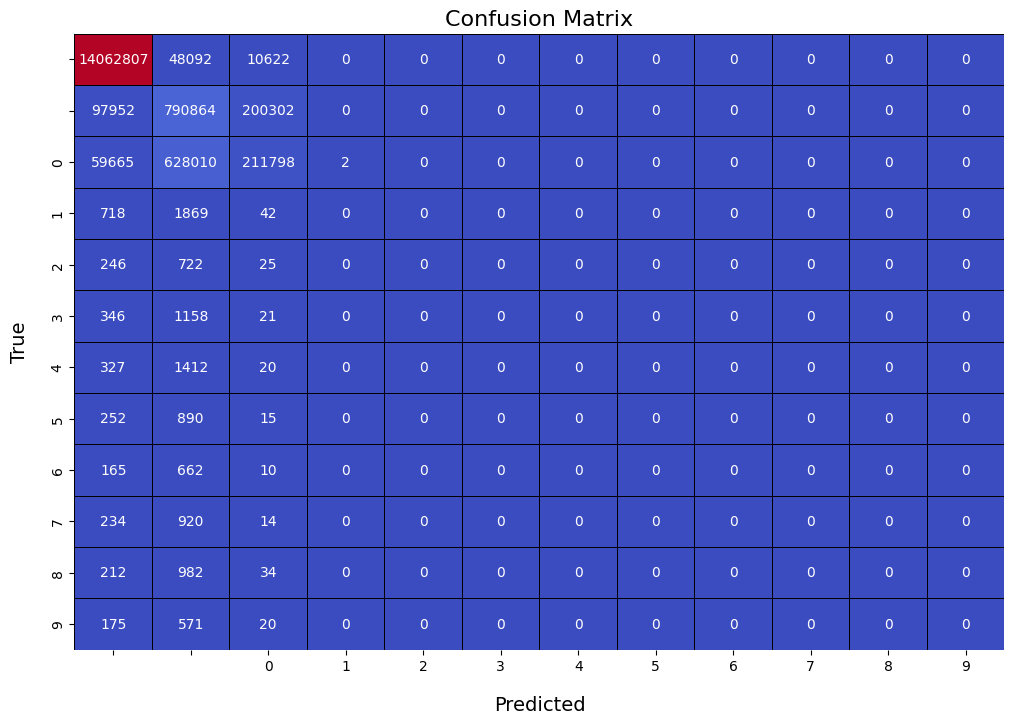

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities on test data
predictions_prob = model.predict(X_test, verbose=0)
predictions = np.argmax(predictions_prob, axis=-1)

# Flatten y_test to match shape
true_tags_flat = np.argmax(y_test, axis=-1).flatten()

# Convert predictions back to NER tags
predicted_tags_flat = predictions.flatten()

# Inverse transform to original labels
true_tags = ner_encoder.inverse_transform(true_tags_flat)
predicted_tags = ner_encoder.inverse_transform(predicted_tags_flat)

# Classification report
report = classification_report(true_tags, predicted_tags)
print(report)

# Compute the confusion matrix
labels = sorted(set(true_tags) | set(predicted_tags))
cm = confusion_matrix(true_tags, predicted_tags, labels=labels)

# Create a custom color map
cmap = plt.cm.get_cmap('coolwarm')

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels, cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

###Analysis and Discussion

• Discuss the strengths and weaknesses of your sequential model based on the evaluation results.

• Suggest potential improvements or alternative approaches to enhance performance.

##Strengths and Weaknesses of the Sequential Model

###Strengths:
Bidirectional LSTM can capture contextual information effectively.
Embedding layer helps in representing words in a dense vector space, capturing semantic relationships.
Softmax activation in the output layer facilitates multi-class classification, suitable for NER tasks.
###Weaknesses:
LSTM may struggle with very long sequences or capturing dependencies over very large contexts.
Model performance heavily depends on the quality and size of the training data and the effectiveness of word embeddings.
Sequential models might not capture complex syntactic or semantic relationships as effectively as transformer models.
This detailed breakdown provides a structured approach to understanding and improving your NER model, covering data preprocessing, model building, evaluation, and potential enhancements. Adjustments and further experimentation can be tailored based on specific task requirements and available resources.

**Alternative Approaches:**
*BERT-based Models:* Pre-trained models like BERT (Bidirectional Encoder Representations from Transformers) can be fine-tuned for NER tasks, leveraging large-scale language representations.

*CRF (Conditional Random Fields)*: Combining LSTM with CRF can improve performance by capturing dependencies between labels directly.

*Ensemble Methods:* Building an ensemble of models (e.g., LSTM, CNNs, Transformers) can often lead to better performance by leveraging diverse predictions.

*Active Learning:* Incorporating active learning strategies to intelligently select and annotate data for model training can optimize performance with limited labeled data.

**Conclusion:**
While the LSTM-based sequential model shows promise for NER tasks, continuous refinement through data enhancement, model optimization, and exploring advanced architectures remains critical. Balancing model complexity with practical deployment considerations will be essential for achieving robust performance in real-world applications.

###Just for record purpose

####Algorithm Breakdown
 **Step 1:** Data Loading and Sampling

- Load Dataset: Load the dataset from a specified path using Pandas.
Uses pd.read_csv to read data from a CSV file.
- Sample Data: Extract a specified percentage of data from the dataset.
Define a function extract_percentage_data to randomly sample a percentage of rows from the dataset.
Uses df.sample to select a subset of rows based on the provided percentage.

**Step 2:** Data Cleaning and Exploration
####Data Cleaning:
- Remove Duplicates: Remove duplicate rows based on all columns.
Uses df.drop_duplicates(inplace=True) to drop duplicate rows.
- Clean Special Characters: Define a function clean_special_characters to remove specified special characters from text data.
Uses text.translate(str.maketrans('', '', special_characters)) to remove special characters from each token.

####Exploratory Data Analysis (EDA):
- Sentence Length Distribution: Visualize the distribution of sentence lengths after cleaning.
Uses Seaborn's histplot to plot the distribution of sentence_lengths.
- NER Tag Frequency: Visualize the frequency of different NER tags after cleaning.
Uses Seaborn's barplot to plot the frequency of ner_tag_counts.

**Step 3:** Word Embedding with Word2Vec
####Tokenization: Tokenize sentences from the 'tokens' column.
- Word2Vec Model Training:
Train a Word2Vec model on the tokenized sentences.
Uses Word2Vec from gensim.models.
- Visualize Embeddings:
Perform Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE) to visualize word embeddings.
Uses PCA and TSNE from sklearn for dimensionality reduction and sns.scatterplot for visualization.
- Word Similarity Evaluation:
Evaluate word similarity, analogy, and semantic compositionality using the trained Word2Vec model.
Uses wv.similarity, wv.most_similar, and custom functions for compositionality evaluation.

**Step 4:** Model Training and Evaluation
- Tokenization and Padding:
Tokenize 'tokens' column using Tokenizer from tensorflow.keras.preprocessing.text.
Pad sequences to a maximum length using pad_sequences from tensorflow.keras.preprocessing.sequence.
- NER Tag Encoding:
Encode NER tags using LabelEncoder from sklearn.preprocessing and convert them to categorical format.
- Train-Test Split:
Split data into training and testing sets using train_test_split from sklearn.model_selection.
- Model Architecture:
Build a Sequential model using Sequential from tensorflow.keras.models with Embedding, Bidirectional LSTM, and Dense layers.
- Model Compilation and Training:
Compile the model with 'adam' optimizer, 'categorical_crossentropy' loss, and 'accuracy' metric.
Train the model on the training data using fit method.
- Model Prediction and Evaluation:
Predict NER tags on the test data and evaluate performance using classification metrics.
Uses predict method for predictions, and classification_report from sklearn.metrics for generating the report.